In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# ---------------------------
# 1. Load Dataset
# ---------------------------
df = pd.read_csv('/content/bank-additional-full.csv', sep=';')
print("Initial dataset shape:", df.shape)
print(df.head())
print(df.info())

# ---------------------------
# 2. Check for Duplicates
# ---------------------------
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Dataset shape after removing duplicates:", df.shape)



Initial dataset shape: (41188, 21)
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  co

In [3]:
# ---------------------------
# 3. Identify Missing Values and Imputation Strategy
# ---------------------------
# Check for actual NaN values
print("Missing values per column:")
print(df.isnull().sum())

# Check for 'unknown' in categorical columns.
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unknowns = (df[col] == 'unknown').sum()
    if unknowns > 0:
        print(f"Column '{col}' has {unknowns} occurrences of 'unknown'.")

# Imputation strategies:
# - using median imputation for numerical columns(robust to outliers).
for col in categorical_cols:
    if (df[col] == 'unknown').sum() > 0:
        mode_val = df[col].mode()[0]
        print(f"Imputing 'unknown' in column '{col}' with mode: {mode_val}")
        df[col] = df[col].replace('unknown', mode_val)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        print(f"Imputing missing values in column '{col}' with median: {median_val}")
        df[col] = df[col].fillna(median_val)



Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
Column 'job' has 330 occurrences of 'unknown'.
Column 'marital' has 80 occurrences of 'unknown'.
Column 'education' has 1730 occurrences of 'unknown'.
Column 'default' has 8596 occurrences of 'unknown'.
Column 'housing' has 990 occurrences of 'unknown'.
Column 'loan' has 990 occurrences of 'unknown'.
Imputing 'unknown' in column 'job' with mode: admin.
Imputing 'unknown' in column 'marital' with mode: married
Imputing 'unknown' in column 'education' with mode: university.degree
Imputing 'unknown' in column 'default' with mode: no
Impu

In [4]:
# ---------------------------
# 4. Removing Weird/Wrong Values
# ---------------------------
# the 'age' column should be within a realistic range.
if 'age' in df.columns:
    wrong_age_count = df[(df['age'] < 0) | (df['age'] > 100)].shape[0]
    print(f"Found {wrong_age_count} rows with 'age' values outside the [0, 100] range.")
    df = df[(df['age'] >= 0) & (df['age'] <= 100)]
    print("Dataset shape after removing weird age values:", df.shape)
print("_______________________________________________")
print("Final dataset shape after cleaning:", df.shape)
print(df.describe(include='all'))


Found 0 rows with 'age' values outside the [0, 100] range.
Dataset shape after removing weird age values: (41176, 21)
_______________________________________________
Final dataset shape after cleaning: (41176, 21)
                age     job  marital          education default housing  \
count   41176.00000   41176    41176              41176   41176   41176   
unique          NaN      11        3                  7       2       2   
top             NaN  admin.  married  university.degree      no     yes   
freq            NaN   10749    25001              13894   41173   22561   
mean       40.02380     NaN      NaN                NaN     NaN     NaN   
std        10.42068     NaN      NaN                NaN     NaN     NaN   
min        17.00000     NaN      NaN                NaN     NaN     NaN   
25%        32.00000     NaN      NaN                NaN     NaN     NaN   
50%        38.00000     NaN      NaN                NaN     NaN     NaN   
75%        47.00000     NaN      NaN

# EDA

<ipython-input-5-0d536a002258>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='y', palette='viridis')


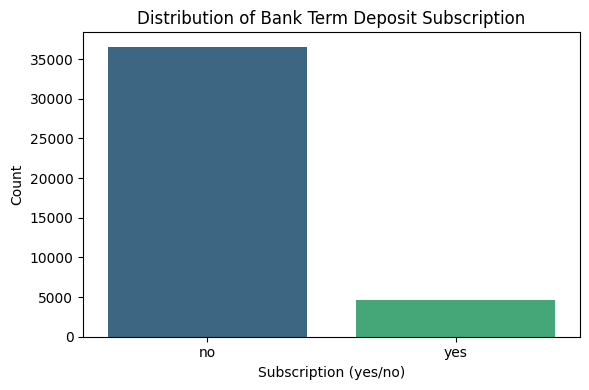

In [5]:
# -----------------------------
# 1. Target Variable Distribution
# -----------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y', palette='viridis')
plt.title('Distribution of Bank Term Deposit Subscription')
plt.xlabel('Subscription (yes/no)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



## Data Insights
### Highly Imbalanced Classes

* The vast majority of clients in this dataset did not subscribe (the “no” category), while a relatively small fraction did (“yes”). This imbalance suggests that any predictive model will need careful handling of the minority class, for instance by using:
  * Alternative metrics (e.g., F1-score, precision-recall) rather than accuracy.
  * **Resampling** techniques (oversampling “yes” cases or undersampling “no” cases) or class weighting in the model.

<ipython-input-6-e9dd972cde31>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, ax=axes[i], palette='viridis')
<ipython-input-6-e9dd972cde31>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, ax=axes[i], palette='viridis')
<ipython-input-6-e9dd972cde31>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, ax=axes[i], palette='viridis')
<ipython-input-6-e9dd972cde31>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` va

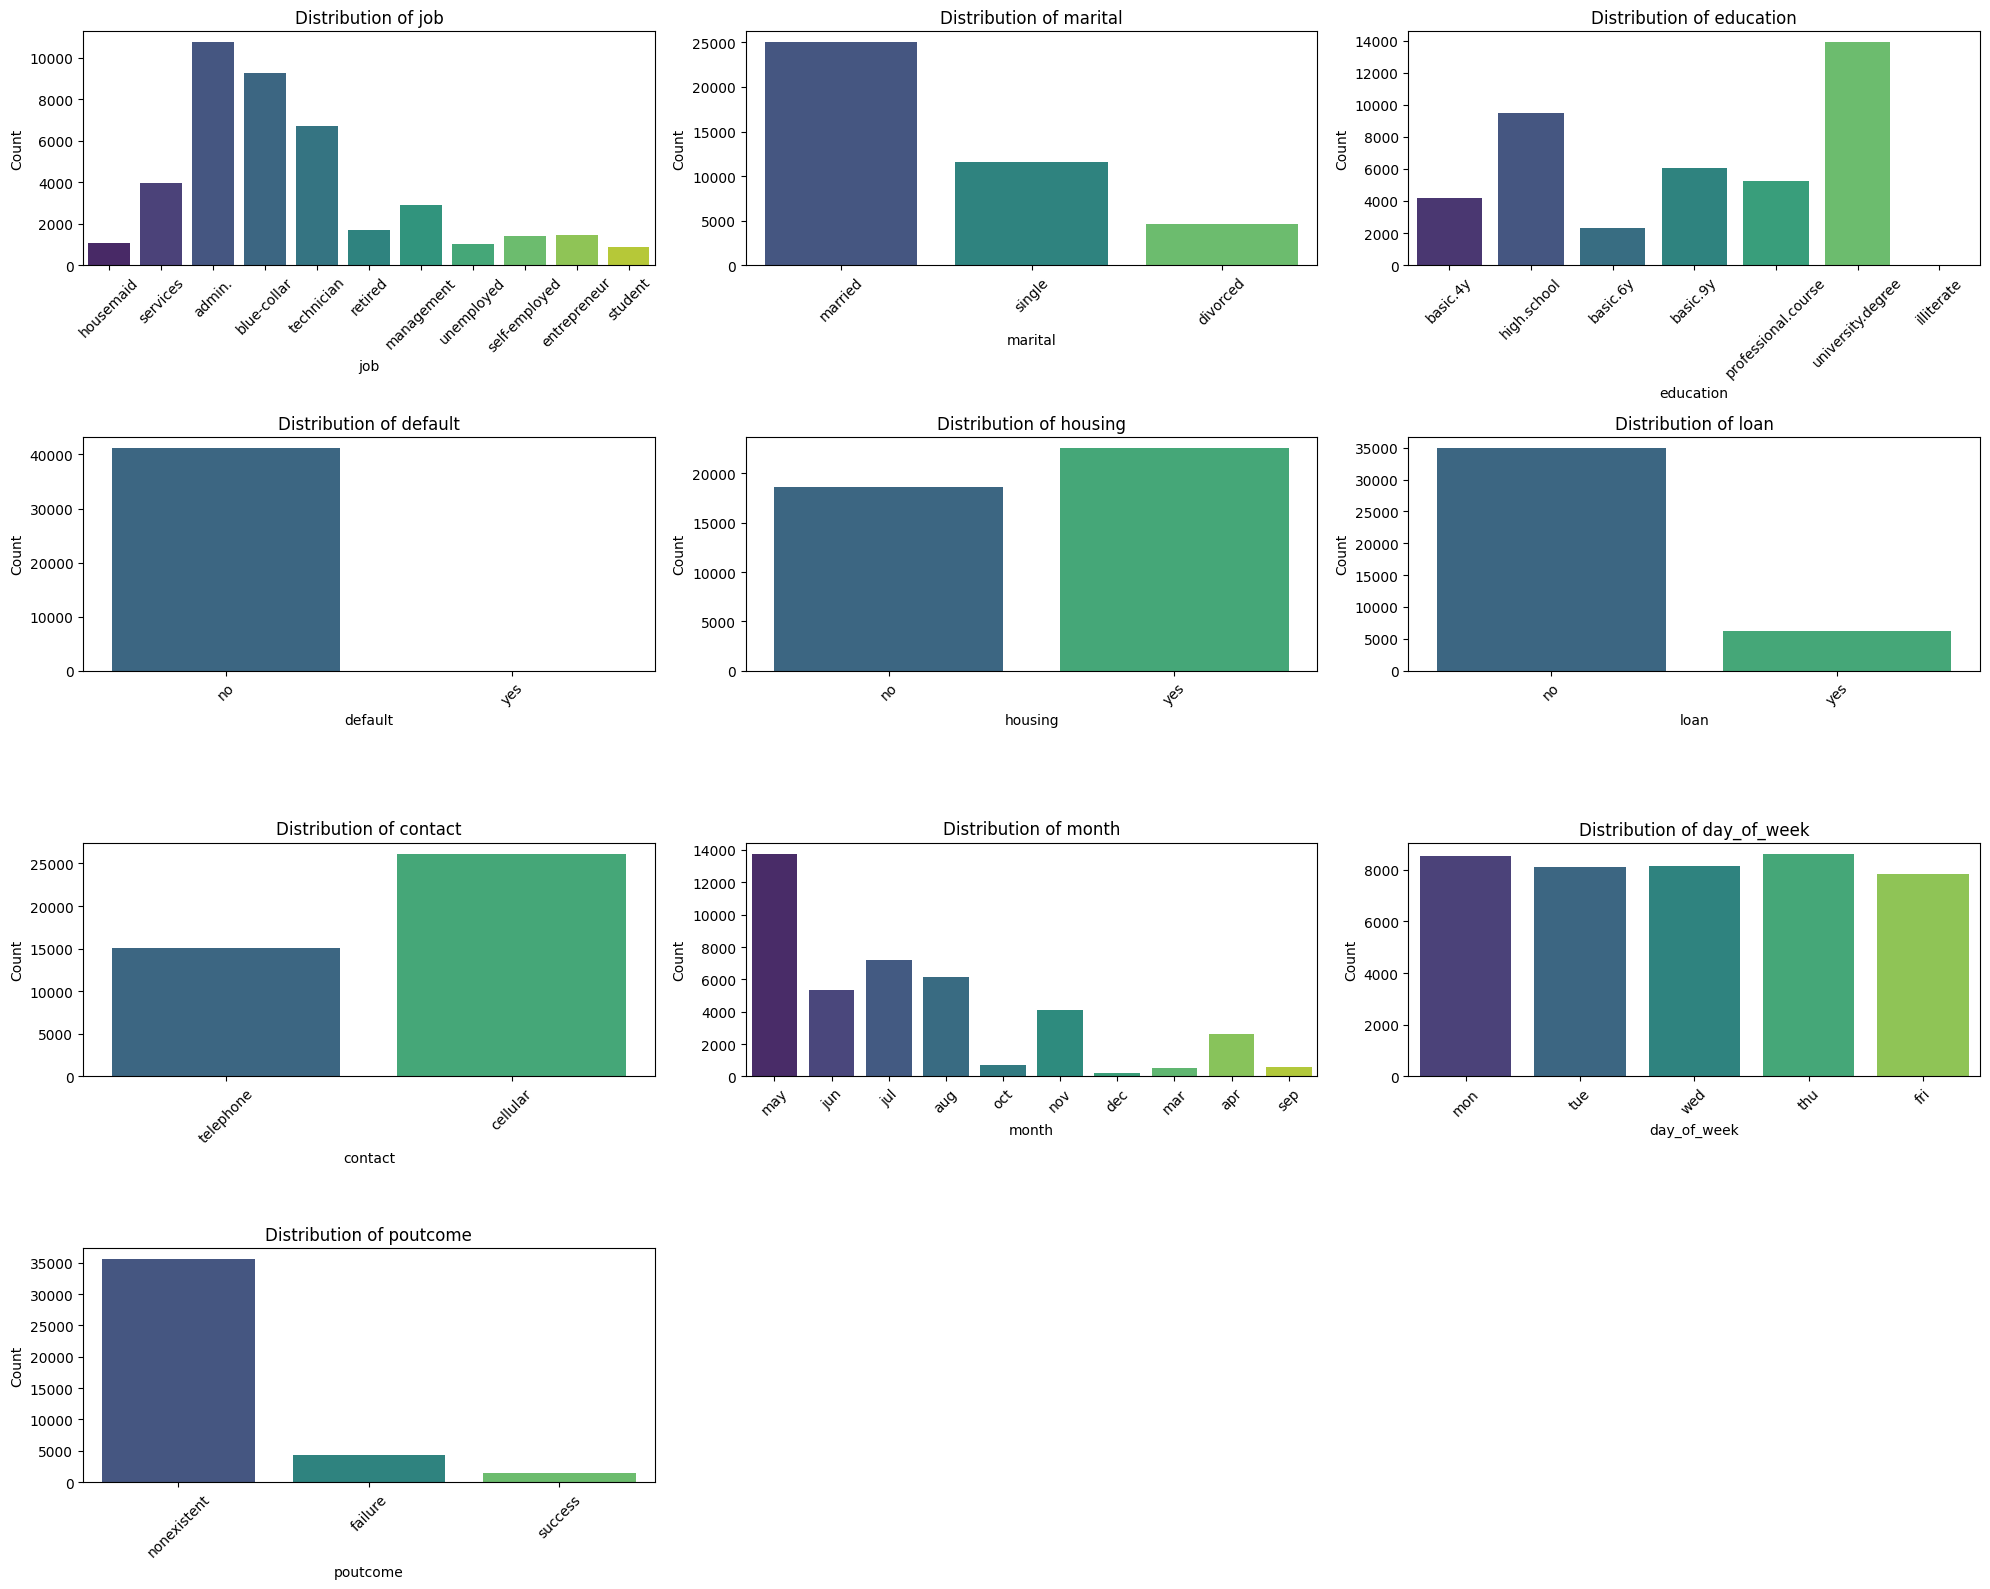

In [6]:
# -----------------------------
# 2. Categorical Variables Visualization
# -----------------------------
categorical_vars = ['job', 'marital', 'education', 'default',
                      'housing', 'loan', 'contact', 'month',
                      'day_of_week', 'poutcome']

n_cols = 3
n_rows = int(np.ceil(len(categorical_vars) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sns.countplot(data=df, x=var, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {var}', fontsize=12)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of variables is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## Data Insights
### 1. Job & Marital Distribution

The largest job categories appear to be “admin” and “blue-collar,” followed by “technician.” In terms of marital status, “married” is the most common category, suggesting a demographic tilt toward married individuals in administrative or blue-collar roles. These dominant groups can be particularly important targets for marketing campaigns, simply because they represent a large share of the overall customer base.

### 2. Contact & Previous Outcome

“Cellular” is by far the most common contact method, reinforcing that mobile outreach is the bank’s primary channel. Meanwhile, the “poutcome” distribution shows that a large number of customers have a “nonexistent” previous outcome, implying they may not have been part of earlier campaigns—or their prior outcomes weren’t recorded. This underscores the importance of first-contact effectiveness and suggests a big portion of the customer base is relatively new to bank marketing efforts.

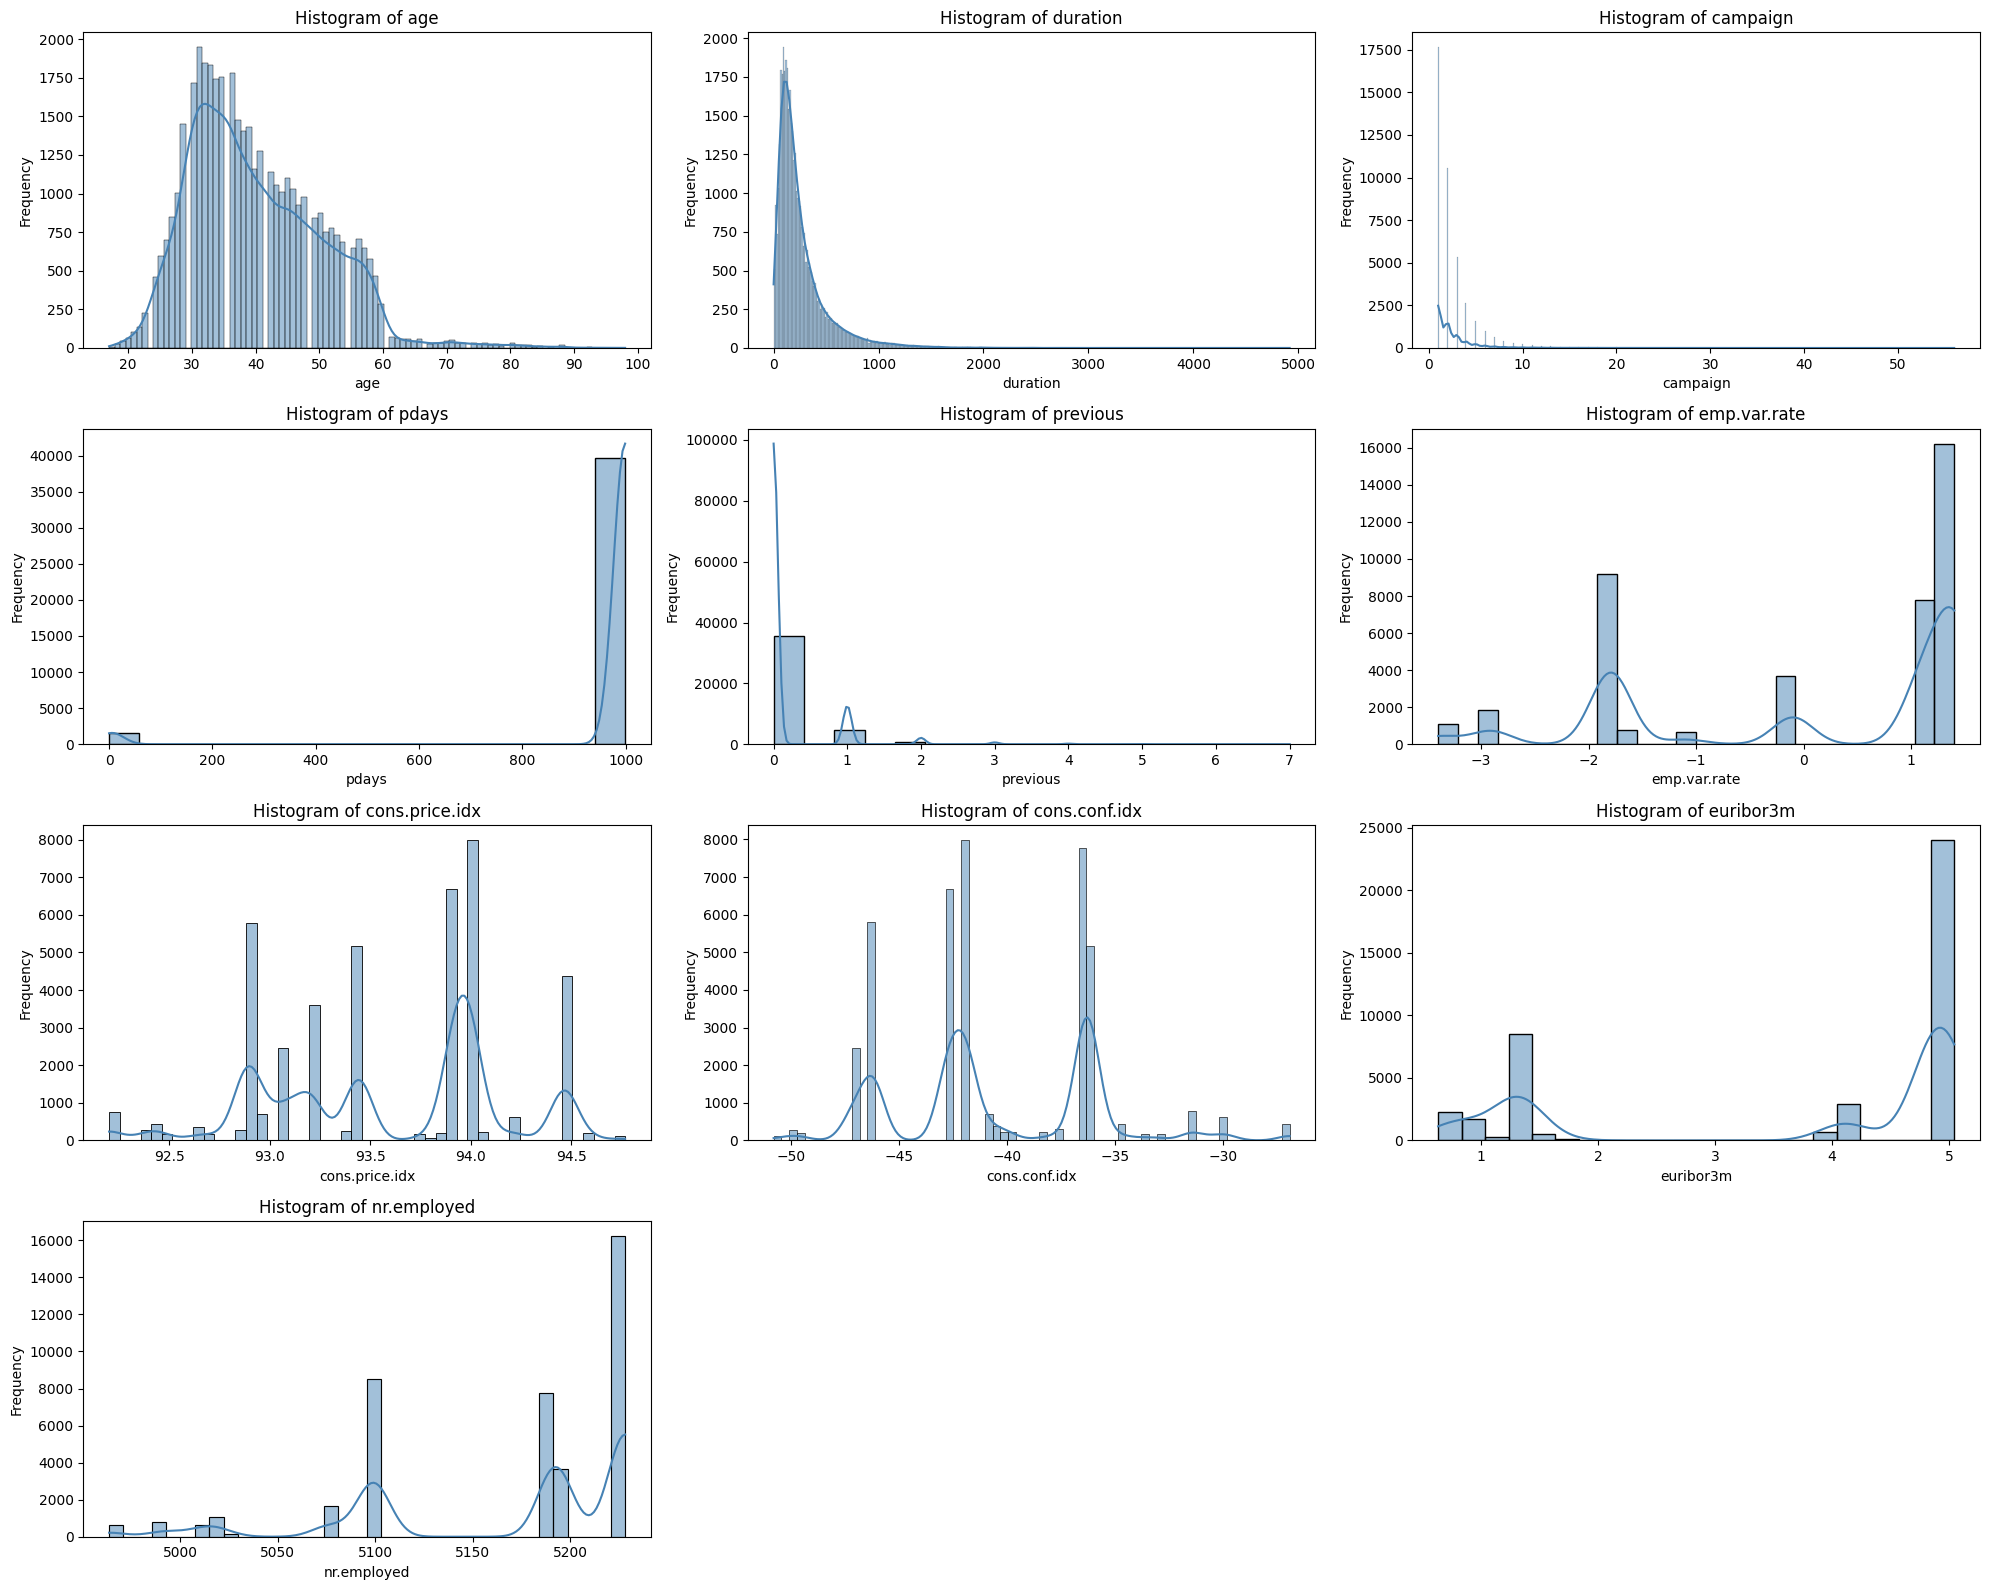

In [7]:
# -----------------------------
# 3. Continuous Variables Visualization
# -----------------------------
# Define a list of continuous variables (adjust list based on your dataset)
continuous_vars = ['age', 'duration', 'campaign', 'pdays', 'previous',
                   'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                   'euribor3m', 'nr.employed']

n_cols = 3
n_rows = int(np.ceil(len(continuous_vars) / n_cols))

# Histogram with KDE for continuous variables
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, var in enumerate(continuous_vars):
    sns.histplot(data=df, x=var, ax=axes[i], kde=True, color='steelblue')
    axes[i].set_title(f'Histogram of {var}', fontsize=12)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




## Data Insights
### 1. Age and Duration Distributions
The age histogram suggests a concentration around middle-aged customers (roughly in their 30s to 50s), with fewer clients at the higher and lower ends.

Duration (the length of the last phone call) shows a pronounced right skew, indicating that most calls are relatively short, but a small fraction can extend for several minutes or more.
### 2. Most Clients Have Few Campaign Contacts, and Many Have Not Been Contacted Previously

campaign (the number of contacts during the current campaign) is also skewed, with most customers being contacted only a small number of times (1-3). A tiny subset has a large number of contacts.

The histograms for pdays and previous typically reveal that many clients either were not previously contacted (e.g., “999” placeholder in some datasets) or have zero past contacts. This indicates a large pool of “new” or less frequently engaged clients.

<ipython-input-8-dcef465e1b3f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='y', y=var, ax=axes[i], palette='viridis')
<ipython-input-8-dcef465e1b3f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='y', y=var, ax=axes[i], palette='viridis')
<ipython-input-8-dcef465e1b3f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='y', y=var, ax=axes[i], palette='viridis')
<ipython-input-8-dcef465e1b3f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign

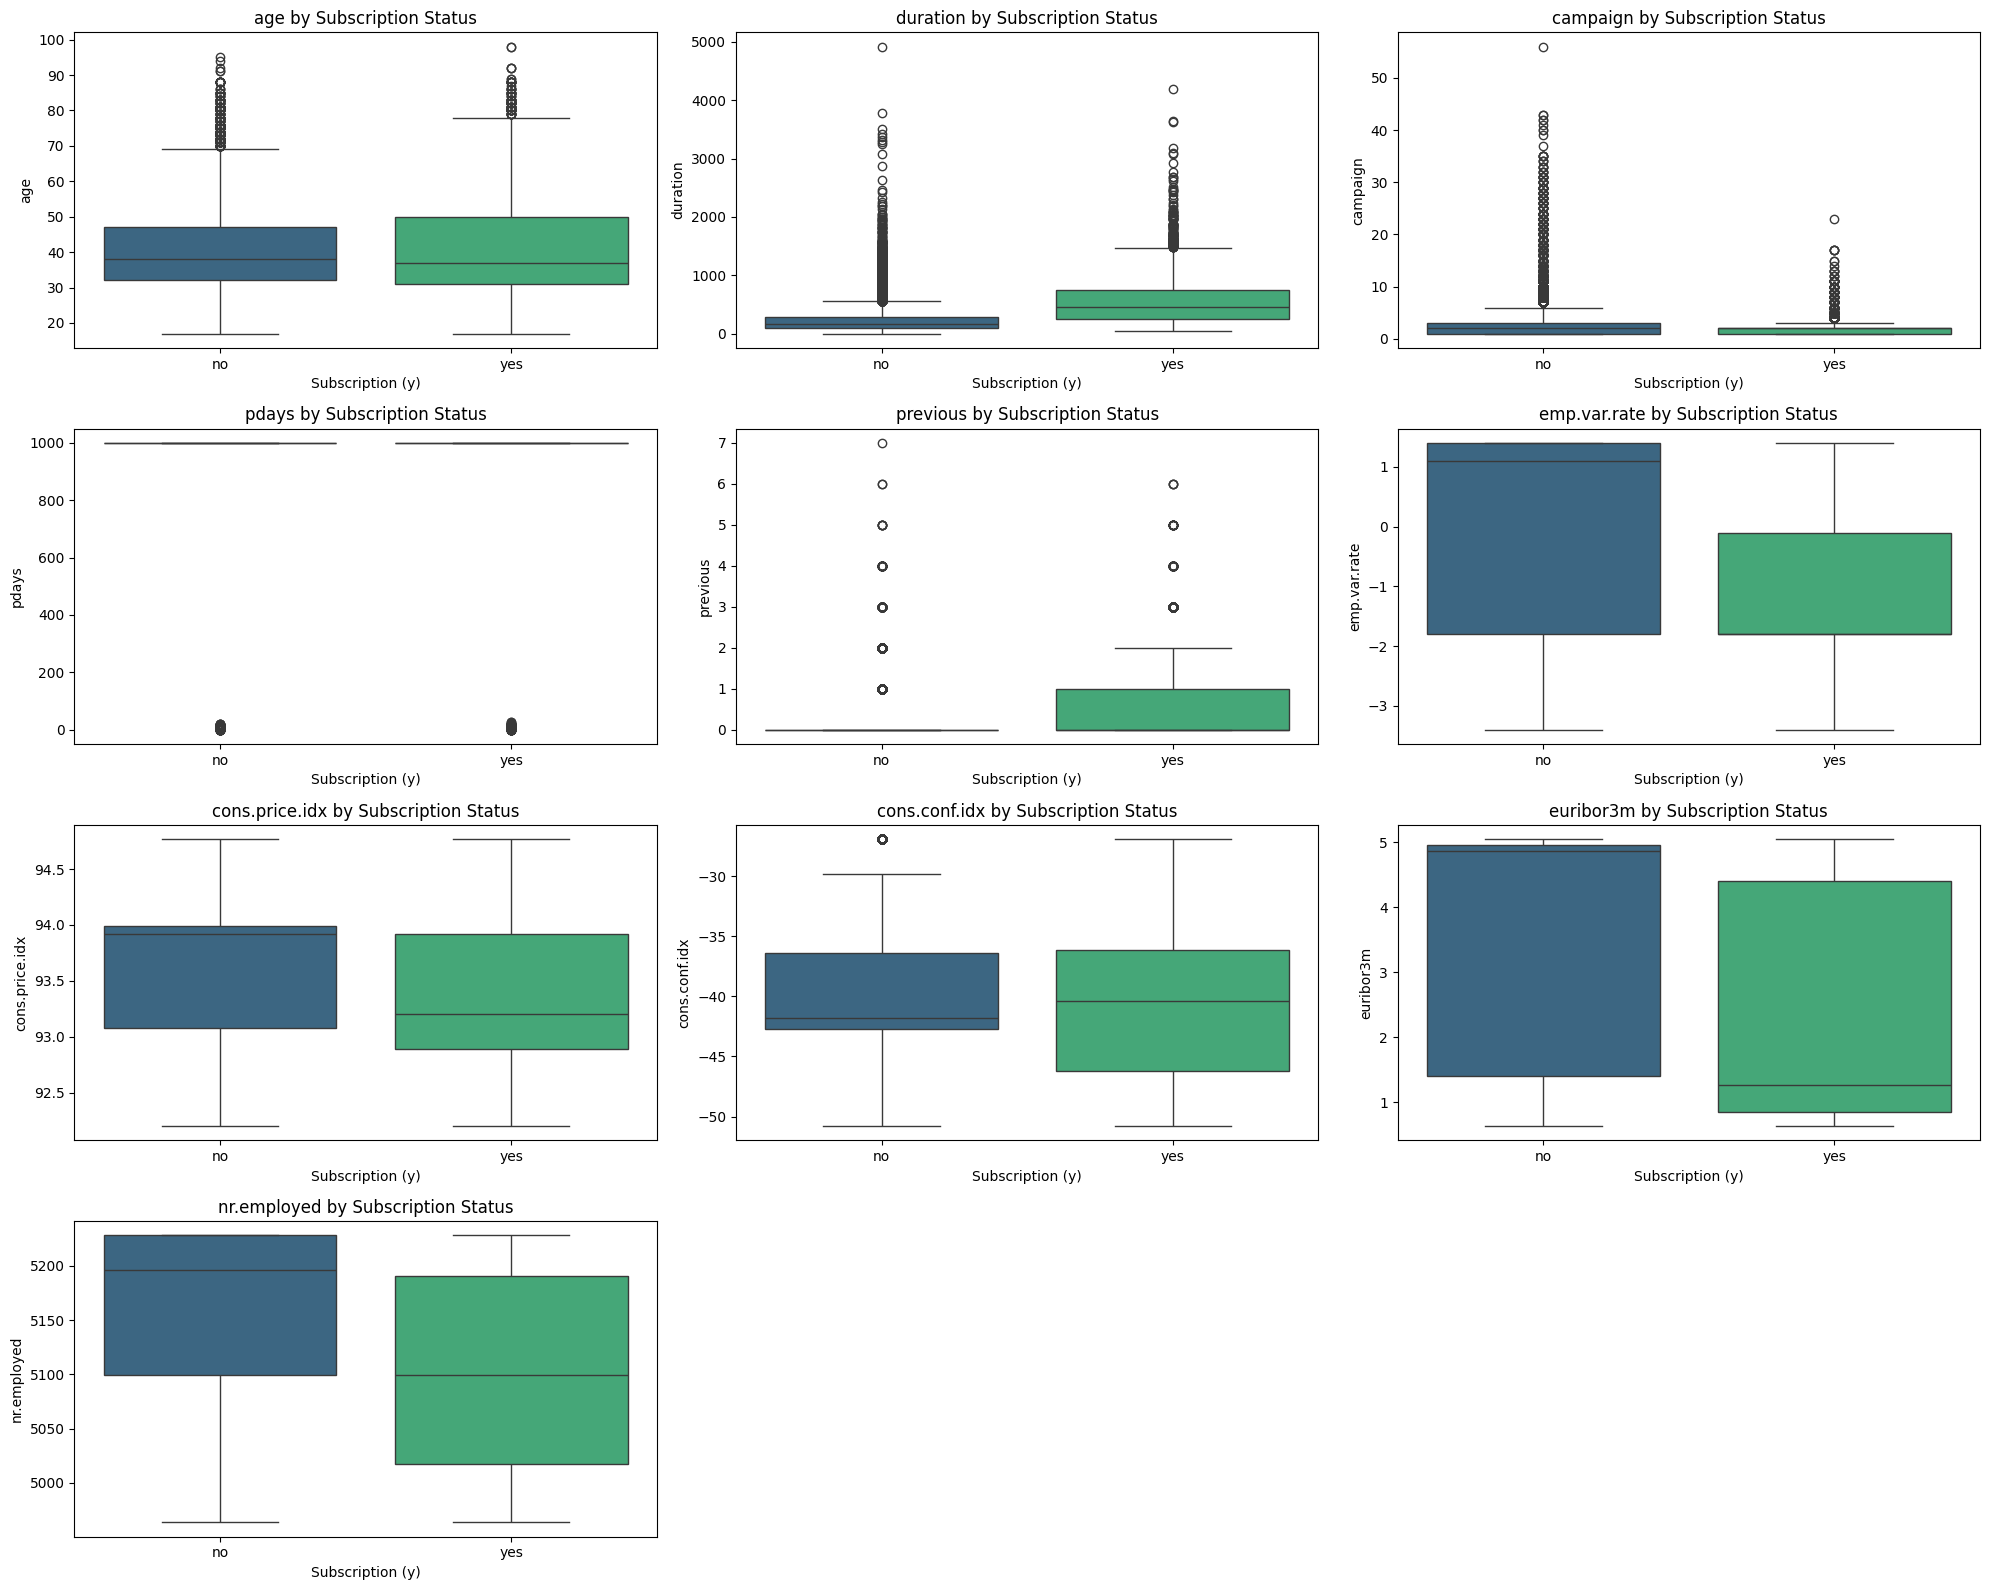

In [8]:
# -----------------------------
# 4. Relationship Between Continuous Variables and Target
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, var in enumerate(continuous_vars):
    sns.boxplot(data=df, x='y', y=var, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{var} by Subscription Status', fontsize=12)
    axes[i].set_xlabel('Subscription (y)', fontsize=10)
    axes[i].set_ylabel(var, fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## Data Insights:
### 1. Longer Call Durations Are Associated With Higher Subscription Rates

The boxplot for “duration” shows that clients who ultimately subscribed (the “yes” group) tend to have significantly longer call durations compared to those who did not subscribe (the “no” group). This suggests that the more time a call center agent spends interacting with a client, the higher the likelihood of securing a term deposit subscription.
### 2. Lower Euribor3m Rates Correlate With More Subscriptions

The “euribor3m” boxplot indicates that clients who subscribed generally experienced a lower three-month Euro Interbank Offered Rate (Euribor3m) compared to those who did not. This could imply that when short-term interest rates are lower, clients may be more inclined to place their money into a term deposit, potentially seeking better returns than those available through other short-term investments.

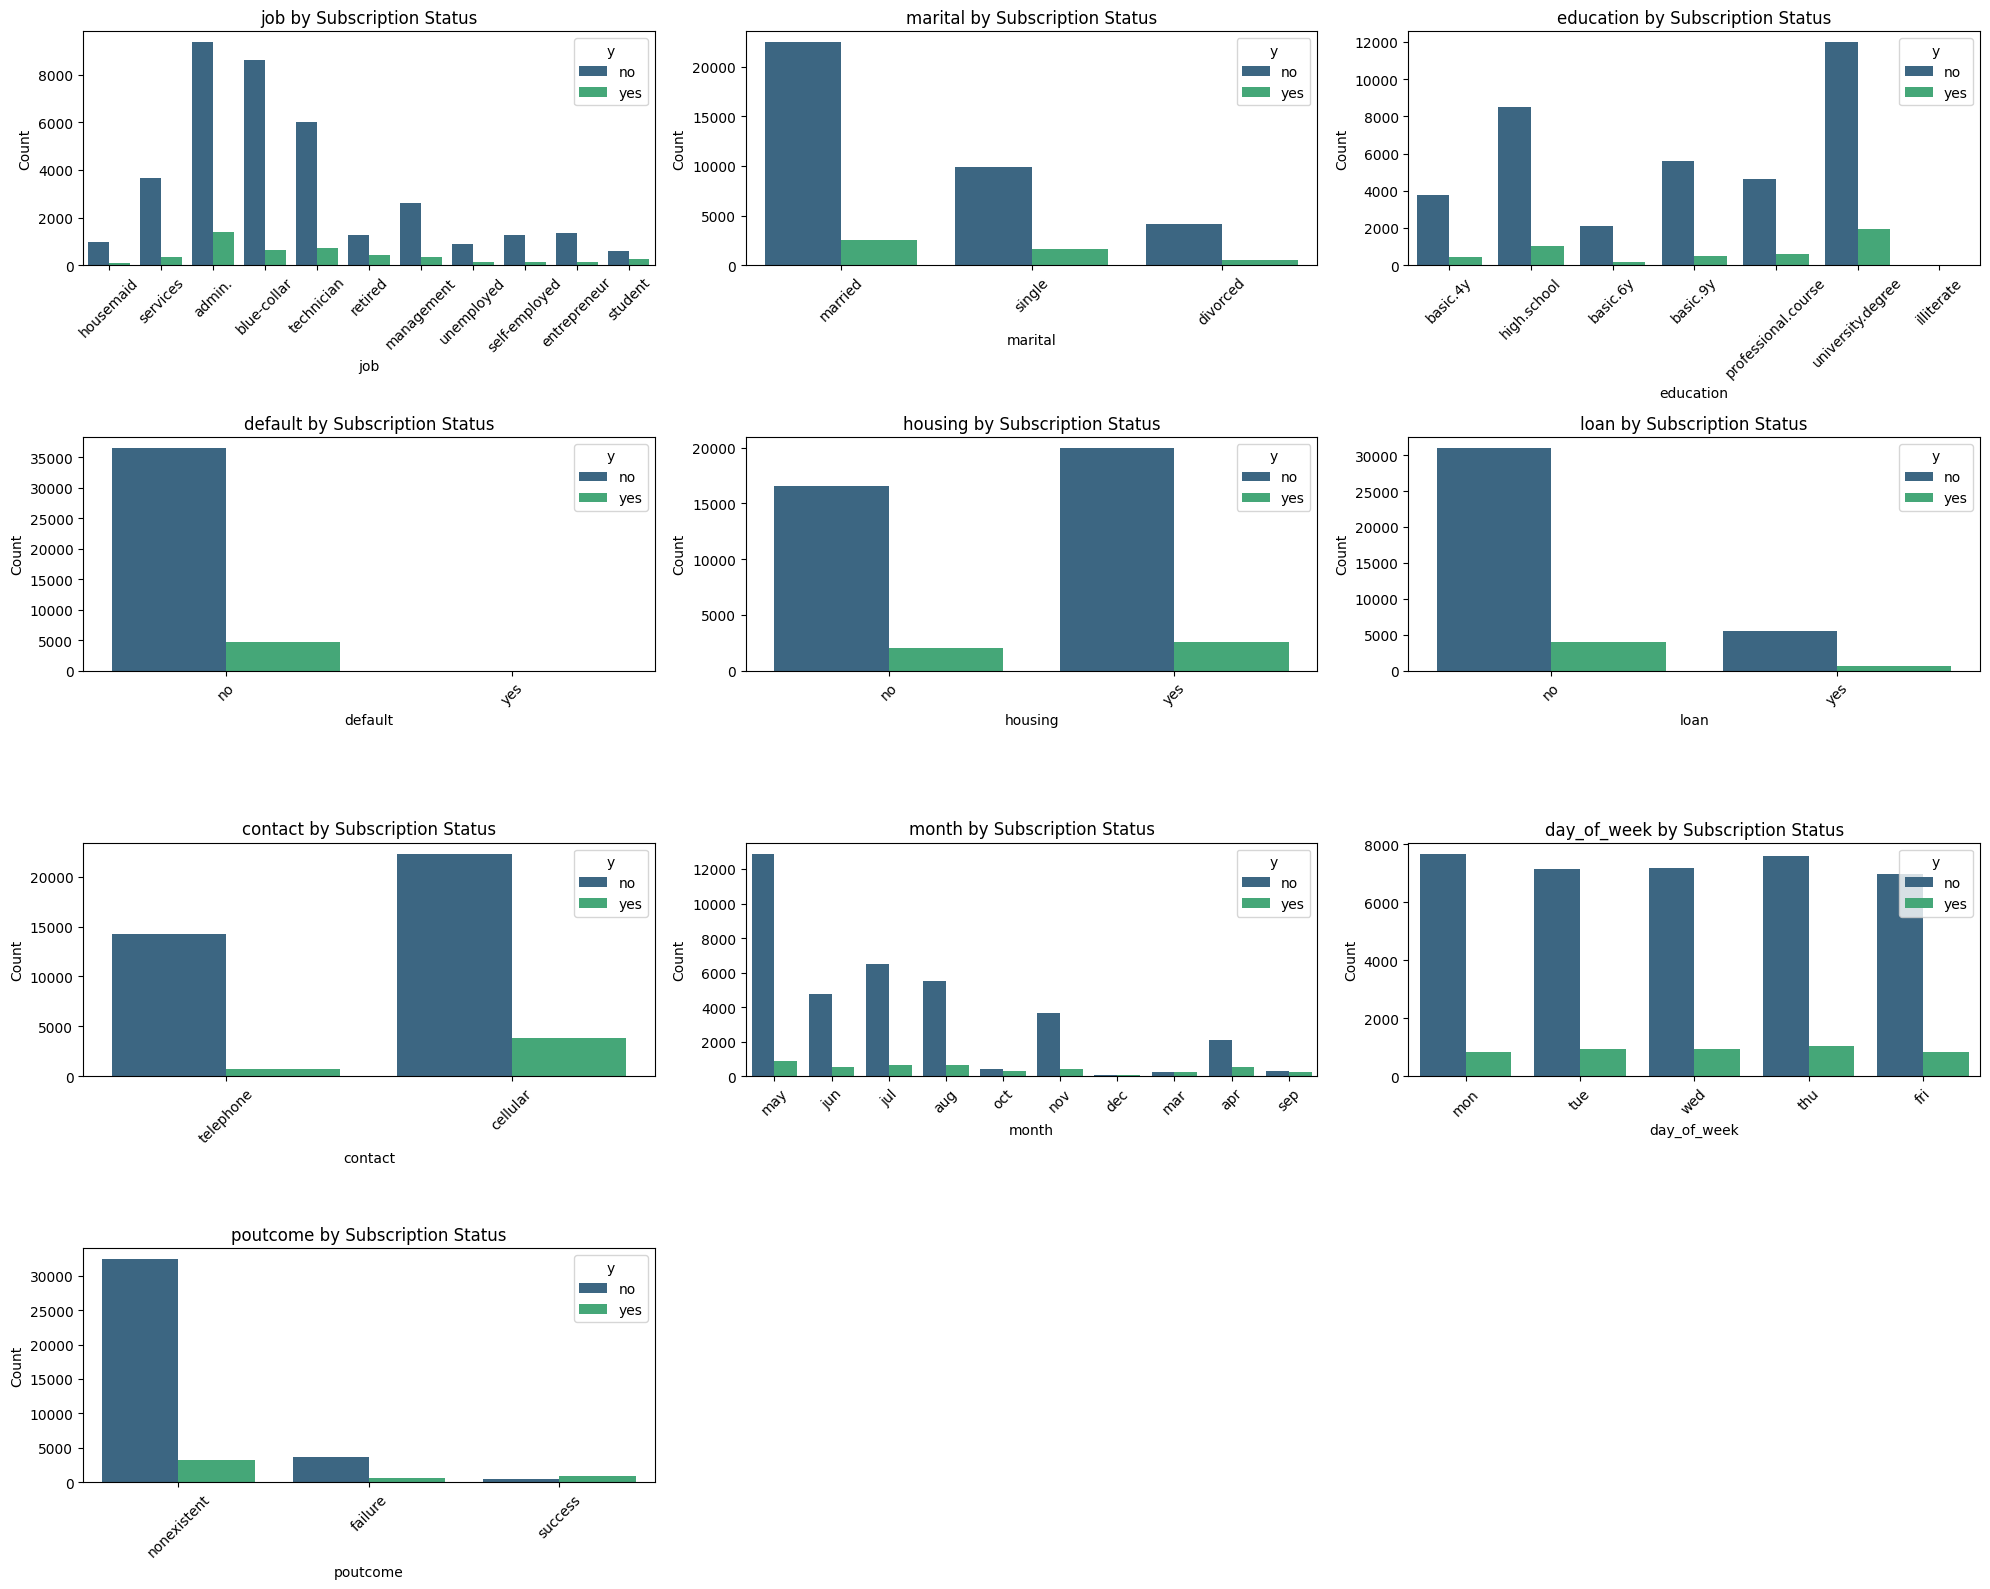

In [9]:
# -----------------------------
# 5. Relationship Between Categorical Variables and Target
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sns.countplot(data=df, x=var, hue='y', ax=axes[i], palette='viridis')
    axes[i].set_title(f'{var} by Subscription Status', fontsize=12)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Data Insights
### 1. Previous Campaign Success Leads to More Subscriptions

From the “poutcome” bar chart, clients whose previous campaign outcome was “success” appear more likely to subscribe (“yes”) in the current campaign. This suggests a strong positive relationship between having a successful prior campaign and subscribing again.

###2. Most Clients Are Contacted via Cellular, Which Also Yields More Subscriptions

The “contact” chart shows that the majority of clients are reached through “cellular” rather than “telephone.” Not only is “cellular” the dominant channel for both “yes” and “no,” but it also accounts for most of the successful subscriptions. This could indicate that mobile outreach is an effective strategy for engaging potential customers.

Subscription Rate by (job, marital, education):
            job   marital            education  subscription_rate  group_size
0        admin.  divorced             basic.4y           0.285714           7
1        admin.  divorced             basic.6y           0.000000          16
2        admin.  divorced             basic.9y           0.052632          76
3        admin.  divorced          high.school           0.097065         443
4        admin.  divorced  professional.course           0.122449          49
..          ...       ...                  ...                ...         ...
196  unemployed    single             basic.6y           0.000000           4
197  unemployed    single             basic.9y           0.240000          25
198  unemployed    single          high.school           0.184615          65
199  unemployed    single  professional.course           0.095238          21
200  unemployed    single    university.degree           0.240385         104

[201 rows x 5 c

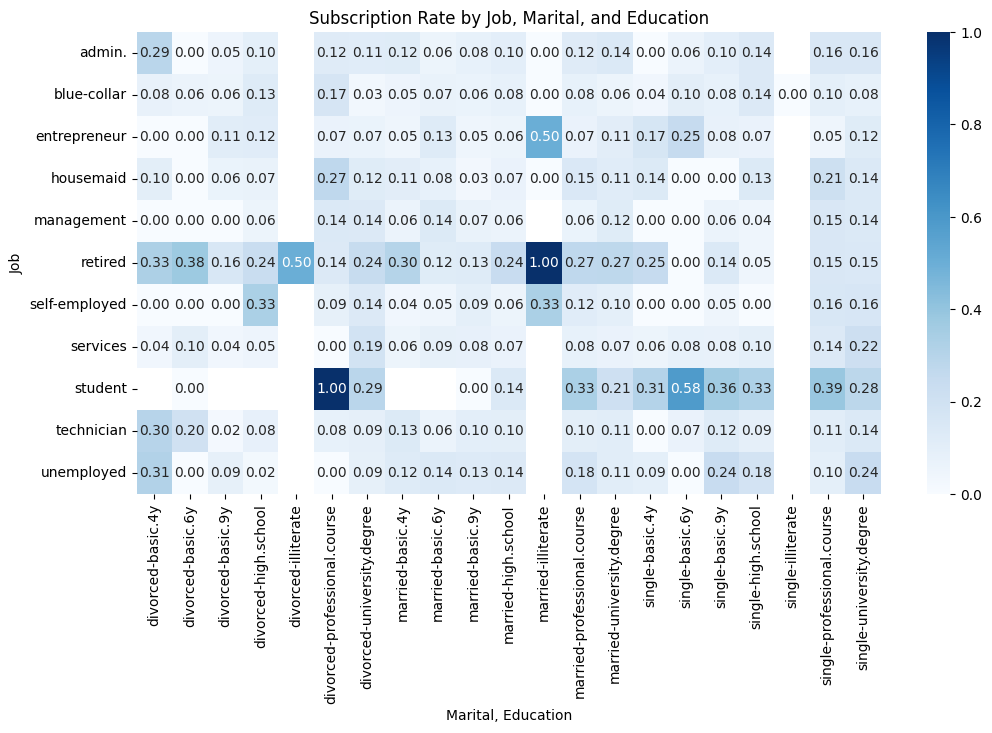

In [10]:
# ---------------------------
#  Convert Target to Numeric
# ---------------------------
df['subscribed'] = df['y'].map({'yes': 1, 'no': 0})

# ---------------------------
#  Groupby for Multivariate Analysis
# ---------------------------
# We compute the mean subscription rate (fraction that said 'yes') and count for each group.
grouped = df.groupby(['job', 'marital', 'education'])['subscribed'].agg(['mean', 'count']).reset_index()
grouped.rename(columns={'mean': 'subscription_rate', 'count': 'group_size'}, inplace=True)

print("Subscription Rate by (job, marital, education):")
print(grouped)
# Create a pivot table to see how subscription rates vary across (job) vs. (marital, education).
pivot_table = pd.pivot_table(
    df,
    values='subscribed',
    index='job',
    columns=['marital', 'education'],
    aggfunc='mean'
)

# ---------------------------
# Heatmap Visualization
# ---------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.2f')
plt.title('Subscription Rate by Job, Marital, and Education')
plt.ylabel('Job')
plt.xlabel('Marital, Education')
plt.show()



In [11]:
# ---------------------------
# Clean up of Target column
# ---------------------------
df = df.drop('subscribed', axis=1)

## Data Insights

### 1. Retirees and Students Show Higher Subscription Rates

The “retired” and “student” categories generally have higher mean subscription rates across different marital and education levels. This could suggest that these segments (possibly due to time availability or financial goals) are more receptive to the term deposit offer.
### 2.Higher Education Tends to Correlate With Greater Subscription

In many job categories, individuals holding a university degree or a professional course often show higher subscription rates compared to those with only basic education. This pattern may indicate that higher-educated clients are either more financially aware or have greater disposable income for savings products.
### 3.Marital Status Influences Outcomes Differently by Job

While “single” individuals in certain jobs (e.g., management, student) often show higher subscription rates, “married” or “divorced” individuals in some lower-income jobs (e.g., blue-collar, housemaid) show comparatively lower subscription rates. This variation suggests that marital status might amplify (or mitigate) the effect of one’s job type on the decision to subscribe.

# Features Engineering Based on EDA Insights

In [12]:
# ---------------------------
# Engineer New Features Based on EDA Insights
# ---------------------------

# Insight 1: Job & Marital Distribution
# Create a flag for customers in key job categories who are married
target_jobs = ['admin.', 'blue-collar', 'technician']
df['target_demographic'] = df.apply(lambda row: 1 if (row['job'] in target_jobs and row['marital'] == 'married') else 0, axis=1)

# Insight 2: Contact & Previous Outcome
# Create a flag if the contact method is cellular
df['is_cellular'] = (df['contact'] == 'cellular').astype(int)
# Create a flag for previous campaign success
df['prev_success'] = (df['poutcome'] == 'success').astype(int)

# Insight 3: Age and Duration Distributions
# Create a flag for middle-aged customers (30-50)
df['middle_age'] = df['age'].apply(lambda x: 1 if 30 <= x <= 50 else 0)
# Create a flag for long call durations (e.g., longer than 200 seconds)
df['long_duration'] = df['duration'].apply(lambda x: 1 if x > 200 else 0)

# Insight 4: Campaign, pdays, and Previous Contacts
# Create a flag for new contacts (pdays=999 implies not previously contacted)
df['new_contact'] = (df['pdays'] == 999).astype(int)

# Insight 5: Education Impact
# Create a flag for higher education (assuming these are the higher education categories)
high_edu = ['professional.course', 'university.degree']
df['high_education'] = df['education'].apply(lambda x: 1 if x in high_edu else 0)

# Insight 6: Interaction between Job & Marital Status
# Create an interaction feature by combining job and marital status
df['job_marital'] = df['job'] + "_" + df['marital']

# ---------------------------
# 3. Quick Inspection of Engineered Features
# ---------------------------
features_to_inspect = [
    'job', 'marital', 'target_demographic',
    'contact', 'is_cellular',
    'poutcome', 'prev_success',
    'age', 'middle_age',
    'pdays', 'new_contact',
    'education', 'high_education',
    'job_marital',
    'duration', 'long_duration'
]
print(df[features_to_inspect].head())


         job  marital  target_demographic    contact  is_cellular  \
0  housemaid  married                   0  telephone            0   
1   services  married                   0  telephone            0   
2   services  married                   0  telephone            0   
3     admin.  married                   1  telephone            0   
4   services  married                   0  telephone            0   

      poutcome  prev_success  age  middle_age  pdays  new_contact  \
0  nonexistent             0   56           0    999            1   
1  nonexistent             0   57           0    999            1   
2  nonexistent             0   37           1    999            1   
3  nonexistent             0   40           1    999            1   
4  nonexistent             0   56           0    999            1   

     education  high_education        job_marital  duration  long_duration  
0     basic.4y               0  housemaid_married       261              1  
1  high.school  

# Data Pre-processing

In [13]:
# SEPARATE FEATURES (X) AND TARGET (y)
X = df.drop('y', axis=1)
y = df['y']

# LABEL ENCODE THE TARGET
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # "yes" -> 1, "no" -> 0

# IDENTIFY NUMERIC AND CATEGORICAL COLUMNS
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'target_demographic', 'is_cellular', 'prev_success', 'middle_age',
       'long_duration', 'new_contact', 'high_education'],
      dtype='object')
Categorical columns: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'job_marital'],
      dtype='object')


In [14]:
# ONE-HOT ENCODE CATEGORICAL FEATURES

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# STANDARD SCALER FOR NUMERICAL FEATURES
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

print("Encoded dataset shape:", X_encoded.shape)
print(X_encoded.columns)

Encoded dataset shape: (41176, 86)
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'target_demographic', 'is_cellular', 'prev_success', 'middle_age',
       'long_duration', 'new_contact', 'high_education', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_married', 'marital_single',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_yes', 'housing_yes', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_wee

In [15]:
# TRAIN–TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.2,
    random_state=42
)

# PRINT SHAPES FOR VERIFICATION
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (32940, 86)
X_test shape: (8236, 86)
y_train shape: (32940,)
y_test shape: (8236,)


In [16]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
y_train_series.value_counts(normalize=True) * 100

,proportion
0,88.864602
1,11.135398


In [17]:
y_test_series.value_counts(normalize=True) * 100

,proportion
0,88.210296
1,11.789704


# Feature Selection

In [18]:
# show the type of column in X_train
print(dict(X_train.dtypes))

{'age': dtype('float64'), 'duration': dtype('float64'), 'campaign': dtype('float64'), 'pdays': dtype('float64'), 'previous': dtype('float64'), 'emp.var.rate': dtype('float64'), 'cons.price.idx': dtype('float64'), 'cons.conf.idx': dtype('float64'), 'euribor3m': dtype('float64'), 'nr.employed': dtype('float64'), 'target_demographic': dtype('float64'), 'is_cellular': dtype('float64'), 'prev_success': dtype('float64'), 'middle_age': dtype('float64'), 'long_duration': dtype('float64'), 'new_contact': dtype('float64'), 'high_education': dtype('float64'), 'job_blue-collar': dtype('bool'), 'job_entrepreneur': dtype('bool'), 'job_housemaid': dtype('bool'), 'job_management': dtype('bool'), 'job_retired': dtype('bool'), 'job_self-employed': dtype('bool'), 'job_services': dtype('bool'), 'job_student': dtype('bool'), 'job_technician': dtype('bool'), 'job_unemployed': dtype('bool'), 'marital_married': dtype('bool'), 'marital_single': dtype('bool'), 'education_basic.6y': dtype('bool'), 'education_bas

Top 20 features selected using mutual information:
['age', 'duration', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'is_cellular', 'prev_success', 'middle_age', 'long_duration', 'new_contact', 'marital_married', 'contact_telephone', 'month_may', 'month_oct', 'poutcome_nonexistent', 'poutcome_success']

Top 20 features based on RandomForest importance:
duration            0.239513
euribor3m           0.091005
age                 0.073305
nr.employed         0.049803
long_duration       0.044244
campaign            0.038583
cons.conf.idx       0.026519
cons.price.idx      0.023671
emp.var.rate        0.023079
pdays               0.021361
housing_yes         0.019129
prev_success        0.017630
poutcome_success    0.016178
middle_age          0.012461
new_contact         0.012412
loan_yes            0.012286
day_of_week_thu     0.011909
day_of_week_mon     0.011755
previous            0.011626
day_of_week_tue     0.011541
dtype: floa

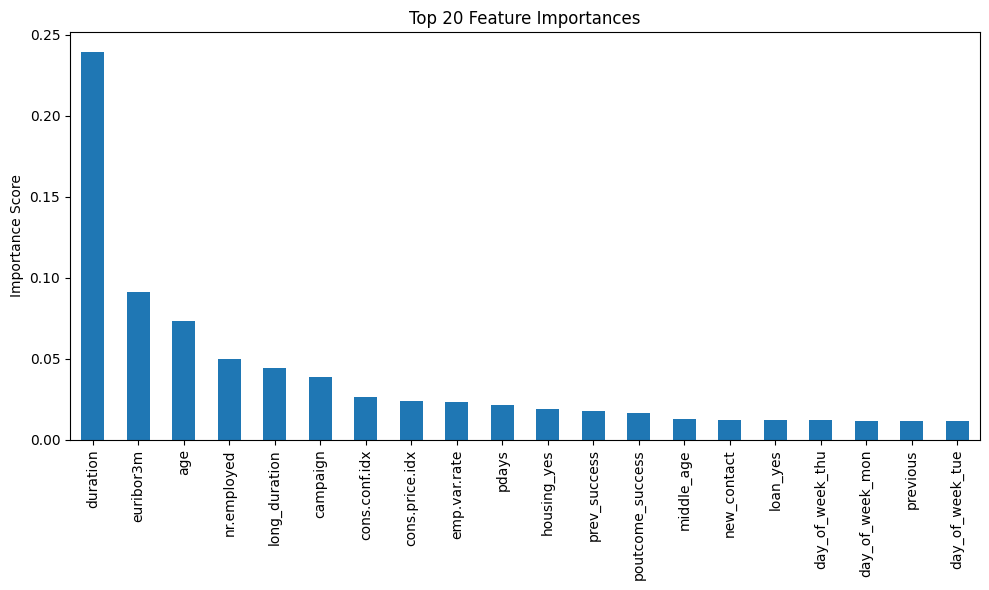

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------------
# Approach 1: Using SelectKBest with Mutual Information
# ----------------------------------
# Select the top k features based on their mutual information with the target.
k = 20  # number of features to select
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_feature_names = X_train.columns[selector.get_support()]

print("Top", k, "features selected using mutual information:")
print(selected_feature_names.tolist())

# ----------------------------------
# Approach 2: Using a RandomForest to Compute Feature Importances
# ----------------------------------
# Fit a random forest classifier to compute feature importances.
rf = RandomForestClassifier(random_state=52)
rf.fit(X_train, y_train)

# Create a Series of feature importances, sorted in descending order.
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("\nTop 20 features based on RandomForest importance:")
print(feature_importances_sorted.head(20))

# Plot the top 20 feature importances.
plt.figure(figsize=(10, 6))
feature_importances_sorted.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [20]:
# Create a DataFrame from the RandomForest top 20 features
rf_top20_df = feature_importances_sorted.head(20).reset_index()
rf_top20_df.columns = ['feature', 'rf_importance']

# Add a column that indicates whether the feature is in the selected_feature_names list from mutual information
rf_top20_df['mutual_info_selected'] = rf_top20_df['feature'].isin(selected_feature_names.tolist())

# Display the combined DataFrame
print(rf_top20_df)

             feature  rf_importance  mutual_info_selected
0           duration       0.239513                  True
1          euribor3m       0.091005                  True
2                age       0.073305                  True
3        nr.employed       0.049803                  True
4      long_duration       0.044244                  True
5           campaign       0.038583                 False
6      cons.conf.idx       0.026519                  True
7     cons.price.idx       0.023671                  True
8       emp.var.rate       0.023079                  True
9              pdays       0.021361                  True
10       housing_yes       0.019129                 False
11      prev_success       0.017630                  True
12  poutcome_success       0.016178                  True
13        middle_age       0.012461                  True
14       new_contact       0.012412                  True
15          loan_yes       0.012286                 False
16   day_of_we

# Modeling process

=== Logistic Regression ===
Accuracy: 0.9031
Confusion Matrix:
[[7068  197]
 [ 601  370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7265
           1       0.65      0.38      0.48       971

    accuracy                           0.90      8236
   macro avg       0.79      0.68      0.71      8236
weighted avg       0.89      0.90      0.89      8236

ROC-AUC Score: 0.9155


=== K-Nearest Neighbors ===
Accuracy: 0.9024
Confusion Matrix:
[[6981  284]
 [ 520  451]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7265
           1       0.61      0.46      0.53       971

    accuracy                           0.90      8236
   macro avg       0.77      0.71      0.74      8236
weighted avg       0.89      0.90      0.90      8236

ROC-AUC Score: 0.8680


=== Decision Tree ===
Accuracy: 0.8898
Confusion Matrix:
[[6827  438]
 [

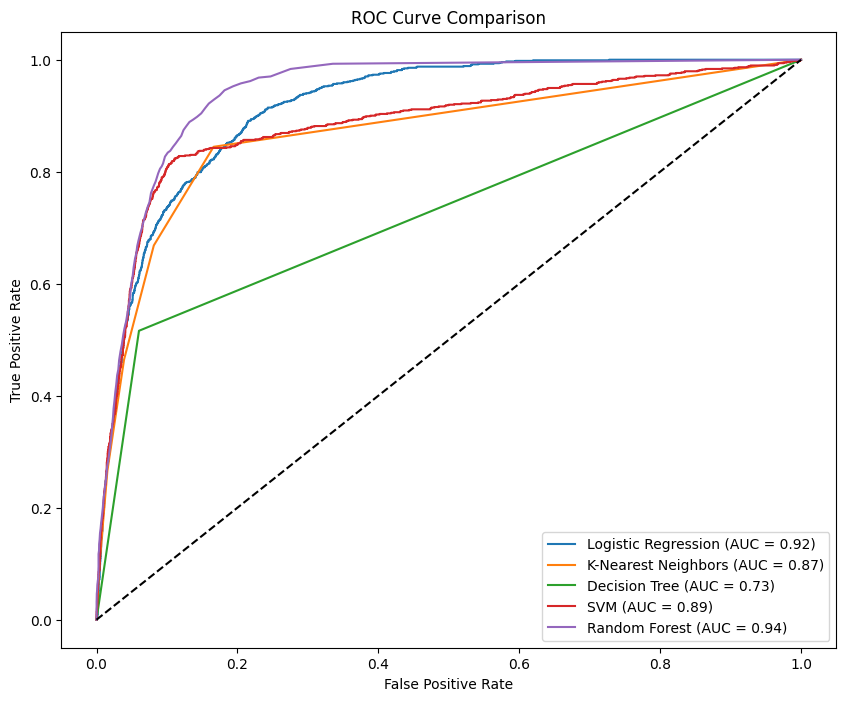

In [21]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

# --------------------------------------------
# 1. Subset the Data Based on Selected Features
# --------------------------------------------
selected_features = rf_top20_df['feature'].tolist()

# Subset X_train and X_test using only the selected features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# --------------------------------------------
# 2. Define the Models
# --------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(random_state=54, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=54),
    "SVM": SVC(probability=True, random_state=54),
    "Random Forest": RandomForestClassifier(random_state=54)
}

# --------------------------------------------
# 3. Train, Evaluate, and Plot ROC Curves
# --------------------------------------------
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_train_sel, y_train)

    # Predictions and probabilities
    y_pred = model.predict(X_test_sel)

    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_sel)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test_sel)

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Display the evaluation metrics
    print(f"=== {name} ===")
    print("Accuracy: {:.4f}".format(acc))
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)
    print("ROC-AUC Score: {:.4f}".format(roc_auc))
    print("\n" + "="*50 + "\n")

    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot the chance line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


## Observation

The classification report clearly shows that the model is performing significantly better on class 0 than on class 1. While class 0 achieves high precision (93%), recall (96%), and f1-score (95%), class 1 lags behind with only **61% precision, 46% recall, and 53% f1-score**. This performance gap is likely due to the severe class imbalance in our dataset (7265 samples for class 0 vs. 971 for class 1), which causes the model to favor the majority class.

To address this imbalance and potentially improve the detection of class 1, we can apply an undersampling technique. By **reducing the number of majority class samples**, we can balance the classes and allow the model to learn the minority class patterns more effectively.

## Undersampling & Model Evaulation

0    3668
1    3668
Name: count, dtype: int64
=== Logistic Regression ===
Accuracy: 0.8424
Confusion Matrix:
[[6120 1145]
 [ 153  818]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7265
           1       0.42      0.84      0.56       971

    accuracy                           0.84      8236
   macro avg       0.70      0.84      0.73      8236
weighted avg       0.91      0.84      0.86      8236

ROC-AUC Score: 0.9210


=== K-Nearest Neighbors ===
Accuracy: 0.8318
Confusion Matrix:
[[6000 1265]
 [ 120  851]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7265
           1       0.40      0.88      0.55       971

    accuracy                           0.83      8236
   macro avg       0.69      0.85      0.72      8236
weighted avg       0.91      0.83      0.86      8236

ROC-AUC Score: 0.9097


=== Decision Tree ===
Accu

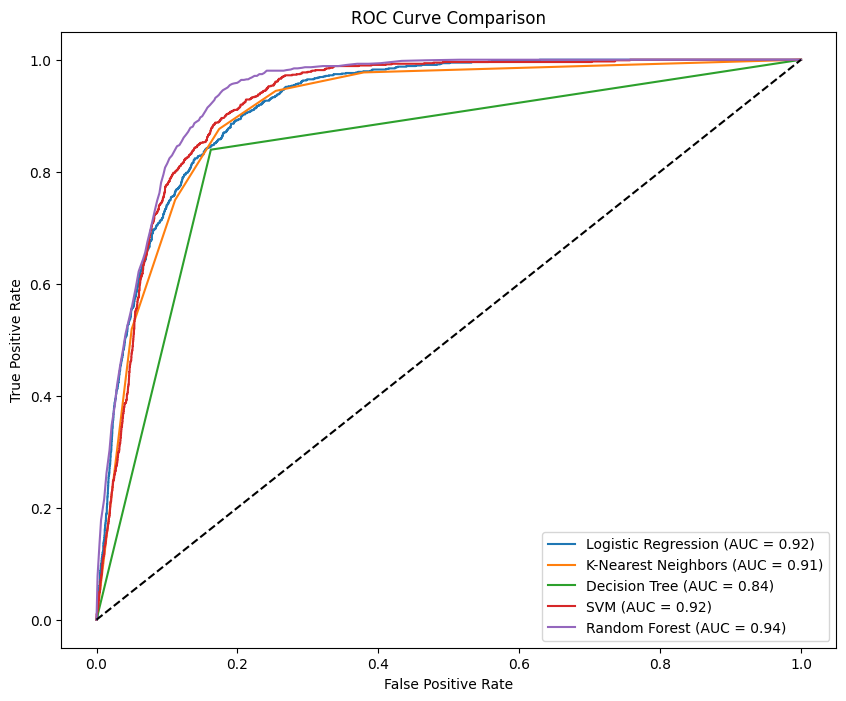

Model Evaluation Metrics:
             Algorithm  Precision    Recall  F1 Score       AUC
0  Logistic Regression   0.416709  0.842430  0.557601  0.920972
1  K-Nearest Neighbors   0.402174  0.876416  0.551344  0.909664
2        Decision Tree   0.408726  0.839341  0.549747  0.838528
3                  SVM   0.389628  0.905252  0.544778  0.923033
4        Random Forest   0.429736  0.922760  0.586387  0.938671


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, roc_curve, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler

# --------------------------------------------
# Undersample the Training Data
# --------------------------------------------
# Use RandomUnderSampler to balance the minority and majority classes in the training set
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_sel, y_train)

# Convert y_train_res to a pandas Series
y_train_res_series = pd.Series(y_train_res)
print(y_train_res_series.value_counts())

# List to store results
results = []

plt.figure(figsize=(10, 8))

# --------------------------------------------
# Train, Evaluate, and Plot ROC Curves for Each Model
# --------------------------------------------
for name, model in models.items():
    # Train the model on the undersampled training data
    model.fit(X_train_res, y_train_res)

    # Predictions on test data
    y_pred = model.predict(X_test_sel)

    # Get predicted probabilities (use decision_function if predict_proba is unavailable)
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_sel)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test_sel)

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Compute precision and recall for the minority class (class 1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Print detailed metrics for review
    print(f"=== {name} ===")
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score: {:.4f}".format(auc))
    print("\n" + "="*50 + "\n")

    # Append the results to the list
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': roc_auc
    })

    # Plot the ROC curve for the current model
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# --------------------------------------------
# 5. Create a Table with the Results
# --------------------------------------------
results_df = pd.DataFrame(results)
print("Model Evaluation Metrics:")
print(results_df)


# Findings Report
## 1. Business Understanding
Objective:
The primary goal is to predict which customers are likely to subscribe to a bank term deposit. This prediction is crucial for optimizing marketing campaigns, as it allows the bank to focus its outreach on clients with a higher likelihood of conversion, ultimately reducing marketing costs and improving the return on investment.

Problem Context:
The dataset is highly imbalanced, with significantly more non-subscribers (class 0) than subscribers (class 1). This imbalance poses a challenge because models tend to favor the majority class, potentially overlooking the smaller yet vital group of subscribers.

## 2. Data Cleaning and Preparation
Notebook Organization:
The analysis is performed in a clean, well-documented notebook. Steps include:
Data Cleaning: Removal of duplicates, handling of missing values, outlier detection, and correcting any anomalous values.

Feature Engineering: Creation of new features based on insights (e.g., job & marital status interactions, call duration thresholds) and transformation of categorical variables through one-hot encoding.

Preprocessing: Scaling of numerical features and encoding of the target variable.
## 3. Model Evaluation: Descriptive & Inferential Statistics (Best Model)
Random Forest without Undersampling:

Overall Accuracy: 90.86%
Confusion Matrix:

True Negatives (Class 0): 6989

False Positives (Class 0 predicted as 1): 276

False Negatives (Class 1 predicted as 0): 477

True Positives (Class 1): 494

Classification Report:

Class 0: High precision (94%), recall (96%), and f1-score (95%)

Class 1: Lower precision (64%), recall (51%), and f1-score (57%)

ROC-AUC: 0.9403

Interpretation:
The model performs well overall but struggles to correctly identify subscribers (class 1), as indicated by the low recall and f1-score for that class. This is a **direct consequence of the class imbalance, where the model is biased toward the majority (non-subscribers).**
###Random Forest with Undersampling:

Overall Accuracy: 84.65%

Confusion Matrix:

True Negatives: 6076

False Positives: 1189

False Negatives: 75

True Positives: 896

Classification Report:

Class 0: Precision of 99%, but recall drops to 84% (f1-score: 91%)

Class 1: Precision drops to 43%, but recall significantly increases to
92% (f1-score: 59%)

ROC-AUC: 0.9387

Interpretation:
By applying undersampling, the model becomes more sensitive to subscribers, achieving a high recall (92%) for class 1. This means the model now **identifies most potential subscribers, although at the cost of increased false positives** (lower precision for class 1). In a business context, this trade-off might be acceptable if the goal is to capture as many potential subscribers as possible, with the understanding that some non-subscribers will also be targeted.

##4. Next Steps and Recommendations
###Hyperparameter Optimization:
Refine the Random Forest model by tuning key hyperparameters (e.g., number of trees, maximum depth, minimum samples per split) using systematic search methods to improve the balance between precision and recall.

###Explore Alternative Sampling Methods:
In addition to undersampling, evaluate oversampling techniques such as SMOTE or ADASYN. This can help generate synthetic minority class examples, potentially offering a better balance between false positives and false negatives.

###Enhance Feature Engineering:
Investigate additional feature interactions and consider dimensionality reduction methods (e.g., PCA) to capture essential patterns, reduce noise, and mitigate potential collinearity among predictors.

###Implement Robust Cross-Validation:
Use stratified k-fold cross-validation to ensure that model performance metrics are reliable and that class distribution is maintained in each fold, thereby validating the model’s generalizability.

###Focus on Model Interpretability and Monitoring:
Integrate explainability techniques (such as SHAP or LIME) to better understand feature contributions and continuously monitor model performance post-deployment to detect data drift or performance degradation over time.

